In [2]:
import os
from dotenv import load_dotenv
from pathlib import Path
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
current_path = Path.cwd()
charts_path = current_path / 'charts'
charts_path.mkdir(exist_ok=True)

### Запрос данных

In [4]:
load_dotenv()

API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

In [5]:
# обозначаем константы

VISITS_FOR_THE_PERIOD = f'{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}'
REGISTRATIONS_FOR_THE_PERIOD = f'{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}'
VISITS_AGENTS_TO_AVOID = ['bot']

In [6]:
# запрашиваем данные, получаем дф

request_visits = requests.get(VISITS_FOR_THE_PERIOD)
request_regs = requests.get(REGISTRATIONS_FOR_THE_PERIOD)

visits_df = pd.DataFrame(request_visits.json())
regs_df = pd.DataFrame(request_regs.json())
ads_df = pd.read_csv('./ads.csv')

### Обработка данных

In [7]:
# фильтруем, группируем данные, мержим общий дф, считаем конвертацию посещение-регистрация, сохраняем итоговый результат


# создаем копии оригинальный фреймов для последующих преобразований
vis, reg =  visits_df.copy(), regs_df.copy()

# преобразовываем даты к типу datetime, оставляем только год-месяц-день
vis['date_group'] = pd.to_datetime(vis['datetime']).dt.date
reg['date_group'] = pd.to_datetime(reg['datetime']).dt.date

# фильтруем посетителей по User-Agent
vis = vis[~vis['user_agent'].str.contains('|'.join(VISITS_AGENTS_TO_AVOID), case=False)] 

# оставляем последние посещения уникальных юзеров сортируем по id и дате
vis = vis.sort_values(by=['visit_id', 'date_group']).drop_duplicates(subset=['visit_id'], keep='last')

#группируем дф'ы
gr_vis = vis.groupby(['date_group', 'platform']).size().reset_index(name='visits')
gr_reg = reg.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

# мержим visits и registrations
visreg_df = pd.merge(gr_vis,
                     gr_reg,
                     on=['date_group', 'platform'],
                     how='outer')

visreg_df['conversion'] = visreg_df['registrations'] / visreg_df['visits']  * 100

#сохраняем итоговой результат
visreg_df.to_json('./conversion.json')

In [8]:
visreg_df.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355


In [9]:
# Получаем данные по рекламе, мержим с дф посещений-регистрации, очищаем данные

ads = ads_df.copy()

# преобразовываем даты к типу datetime, оставляем только год-месяц-день
ads['date_group'] = pd.to_datetime(ads['date']).dt.date

#аггрегируем данные
gr_ads = ads.groupby(['date_group', 'utm_campaign']).agg({'cost': 'sum'}).reset_index()

# мерджим с visits и registrations
df = pd.merge(visreg_df, gr_ads,
              on='date_group',
              how='left').sort_values(by=['date_group'])

# заполняем пустые значения, если не было рекламы  в определенные дни
df['utm_campaign'] = df['utm_campaign'].fillna('none')
df['cost'] = df['cost'].fillna(0)

# убедимся, что в общем дф'е не осталось NaN значений
df.isnull().sum() 

#оставим только нужные нам столбцы
required_df = df[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign', 'platform']]

#сохраняем итоговой результат
required_df.to_json('./ads.json')

In [10]:
required_df.head()

,date_group,visits,registrations,cost,utm_campaign,platform
0,2023-03-01,75,61,212.0,advanced_algorithms_series,android
1,2023-03-01,22,18,212.0,advanced_algorithms_series,ios
2,2023-03-01,279,8,212.0,advanced_algorithms_series,web
3,2023-03-02,67,59,252.0,advanced_algorithms_series,android
4,2023-03-02,31,24,252.0,advanced_algorithms_series,ios


### Визуализация данных

In [11]:
# подготовим дфы для построения чартов


df_for_charts = df.copy()

# для удобства восприятия графика сгруппируем даты по неделям
df_for_charts['date_group'] =  pd.to_datetime(df_for_charts['date_group'])
df_for_charts['date_group'] = df_for_charts['date_group'].dt.to_period(freq='W').dt.end_time.dt.date

#аггрегируем по дням и платформам
gr_dates = df_for_charts.groupby(['date_group']).sum(['visits', 'registrations']).reset_index()
gr_dates_pltf = df_for_charts.groupby(['date_group', 'platform']).sum(['visits', 'registarations']).reset_index()

#получаем конверсию посещение-регистрация
gr_dates['conversion'] = (gr_dates['registrations'] / gr_dates['visits'] * 100)
gr_dates_pltf['conversion']= (gr_dates_pltf['registrations'] / gr_dates_pltf['visits'] * 100)

#получим данные отдельно по платформам
android = gr_dates_pltf[gr_dates_pltf['platform'] == 'android']
ios = gr_dates_pltf[gr_dates_pltf['platform'] == 'ios']
web = gr_dates_pltf[gr_dates_pltf['platform'] == 'web']

#данные по продолжительности рекламных кампаний
gr_ads_dates = df_for_charts.groupby('utm_campaign')['date_group'].agg(['min', 'max']).reset_index()
gr_ads_dates = gr_ads_dates[gr_ads_dates['utm_campaign'] != 'none']

#словарь цветов для унификации графиков
charts_colors = {'visits': '#FFC873',
                'registrations': '#FF7400',
                'ios': '#FFBD40',
                'android': '#009D91',
                'web': '#3F2D84',
                'advanced_algorithms_series': '#5FBDCE',
                'intro_to_python_course': '#65E080',
                'ui_ux_design_drive': '#707ED7',
                'virtual_reality_workshop': '#009B95',
                'women_in_tech_symposium': '#FE7276'}

                


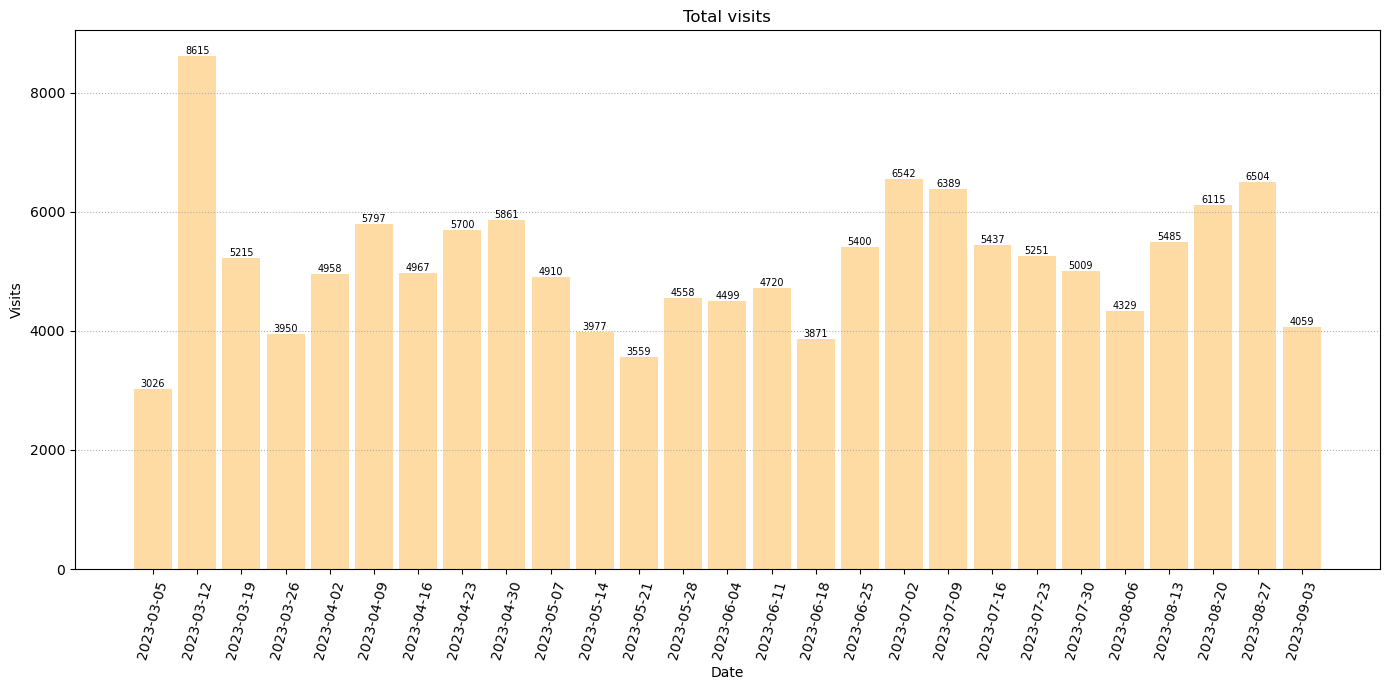

In [12]:
# визиты

fig, ax = plt.subplots(figsize=(14, 7))

# gr_dates['visits'].mean()
# plt.axhline(y=gr_dates['visits'].mean(),       # линия среднего кол-ва посетителей для презентации 
#             linestyle='--',
#             linewidth=1,
#             label="average number of visits")

ax.bar(gr_dates['date_group'],
       gr_dates['visits'],
       color = charts_colors['visits'],
       width = 6,
       alpha=0.65)

ax.set(xlabel='Date',
       ylabel='Visits',
       title='Total visits')

ax.bar_label(ax.containers[0],
             fontsize=7,
             padding=0)

plt.xticks(gr_dates['date_group'],
           rotation=75)

ax.grid(axis='y', ls=':')

plt.tight_layout()
plt.savefig('./charts/total_visits.png')
plt.show()

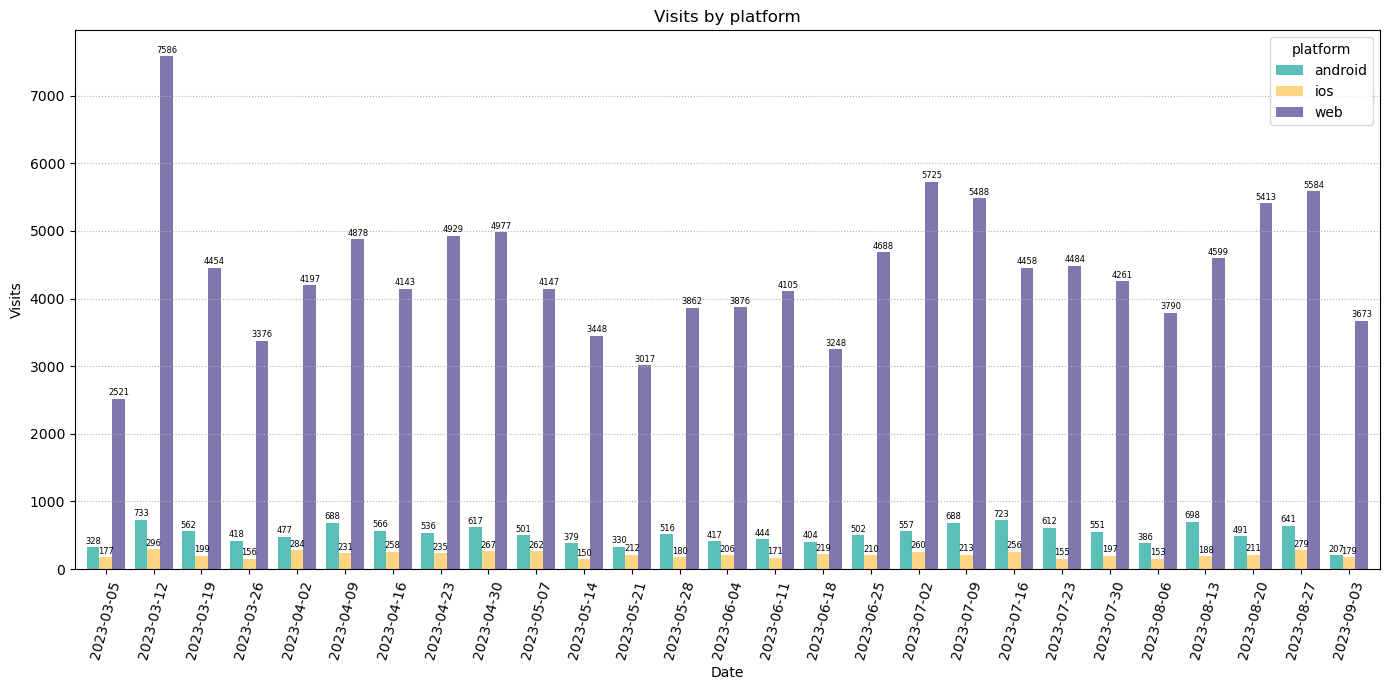

In [13]:
# визиты в разрезе платформы


fig, ax = plt.subplots(figsize=(14, 7))


pivot_pltf = gr_dates_pltf.pivot_table(index='date_group',
                                       columns='platform',
                                       values='visits')
pivot_pltf.plot(kind='bar',
                ax=ax,
                stacked=False,
                width=0.8,
                alpha=0.65,
                color={"ios": charts_colors['ios'],
                       "android": charts_colors['android'],
                       "web": charts_colors['web']})

ax.set(xlabel='Date',
       ylabel='Visits',
       title='Visits by platform')


for i in ax.containers:
    ax.bar_label(i,
                 padding=1,
                 fontsize=6,
                 label_type='edge')


plt.xticks(rotation=75)
plt.grid(axis='y', ls=':')

plt.tight_layout()
plt.savefig('./charts/visits_by_platform.png')
plt.show()

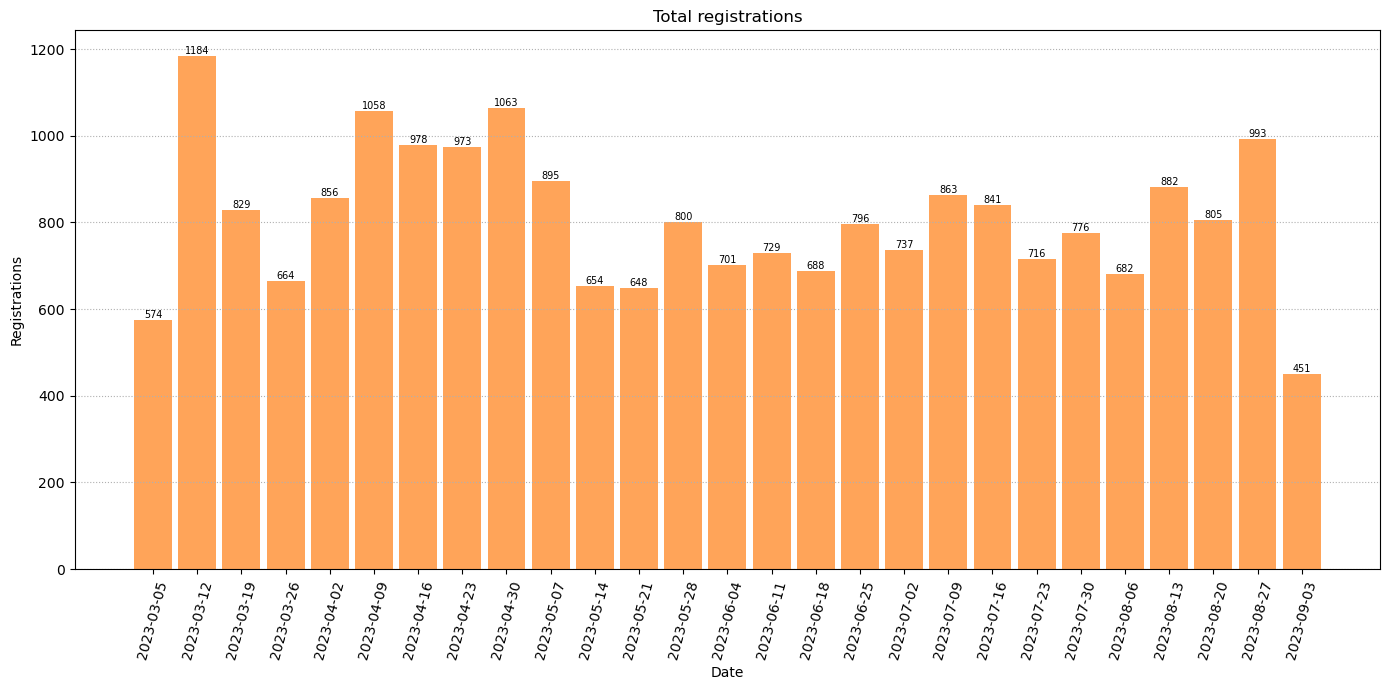

In [14]:
# регистрации

fig, ax = plt.subplots(figsize=(14, 7))

# gr_dates['registrations'].mean()
# plt.axhline(y=gr_dates['registrations'].mean(),       # линия среднего кол-ва регистраций для презентации 
#             linestyle='--',
#             linewidth=1,
#             label="average number of regs")

ax.bar(gr_dates['date_group'],
       gr_dates['registrations'],
       color = charts_colors['registrations'],
       width = 6,
       alpha = 0.65)

ax.set(xlabel='Date',
       ylabel='Registrations',
       title='Total registrations')

ax.bar_label(ax.containers[0],
             fontsize=7,
             padding=0)

plt.xticks(gr_dates['date_group'],
           rotation=75)

ax.grid(axis='y', ls=':')

plt.tight_layout()
plt.savefig('./charts/total_registrations.png')
plt.show()

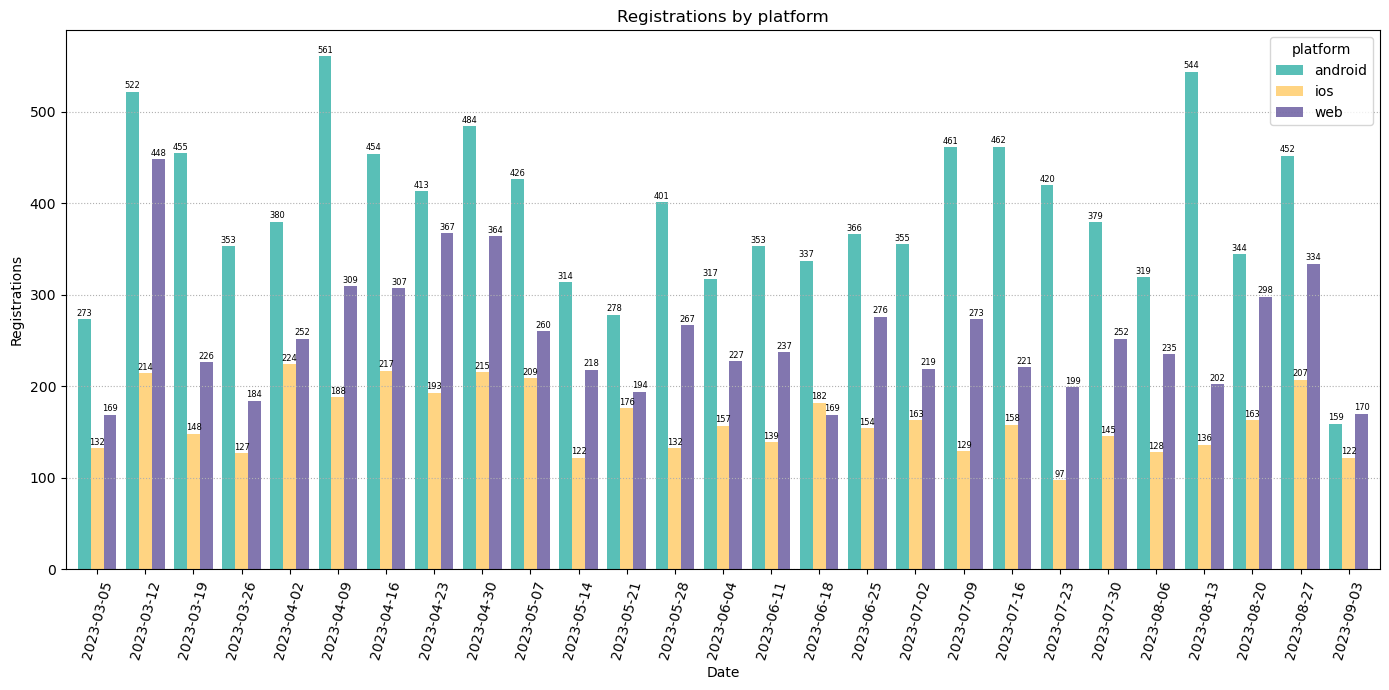

In [15]:
# регистрации в разрезе платформы


fig, ax = plt.subplots(figsize=(14, 7))

pivot_pltf = gr_dates_pltf.pivot_table(index='date_group',
                                       columns='platform',
                                       values='registrations')
pivot_pltf.plot(kind='bar',
                ax=ax,
                stacked=False,
                width=0.8,
                alpha=0.65,
                color={"ios": charts_colors['ios'],
                       "android": charts_colors['android'],
                       "web": charts_colors['web']})

ax.set(xlabel='Date',
       ylabel='Registrations',
       title='Registrations by platform')


for i in ax.containers:
    ax.bar_label(i,
                 padding=1,
                 fontsize=6,
                 label_type='edge')


plt.xticks(rotation=75)
plt.grid(axis='y', ls=':')

plt.tight_layout()
plt.savefig('./charts/registrations_by_platform.png')
plt.show()

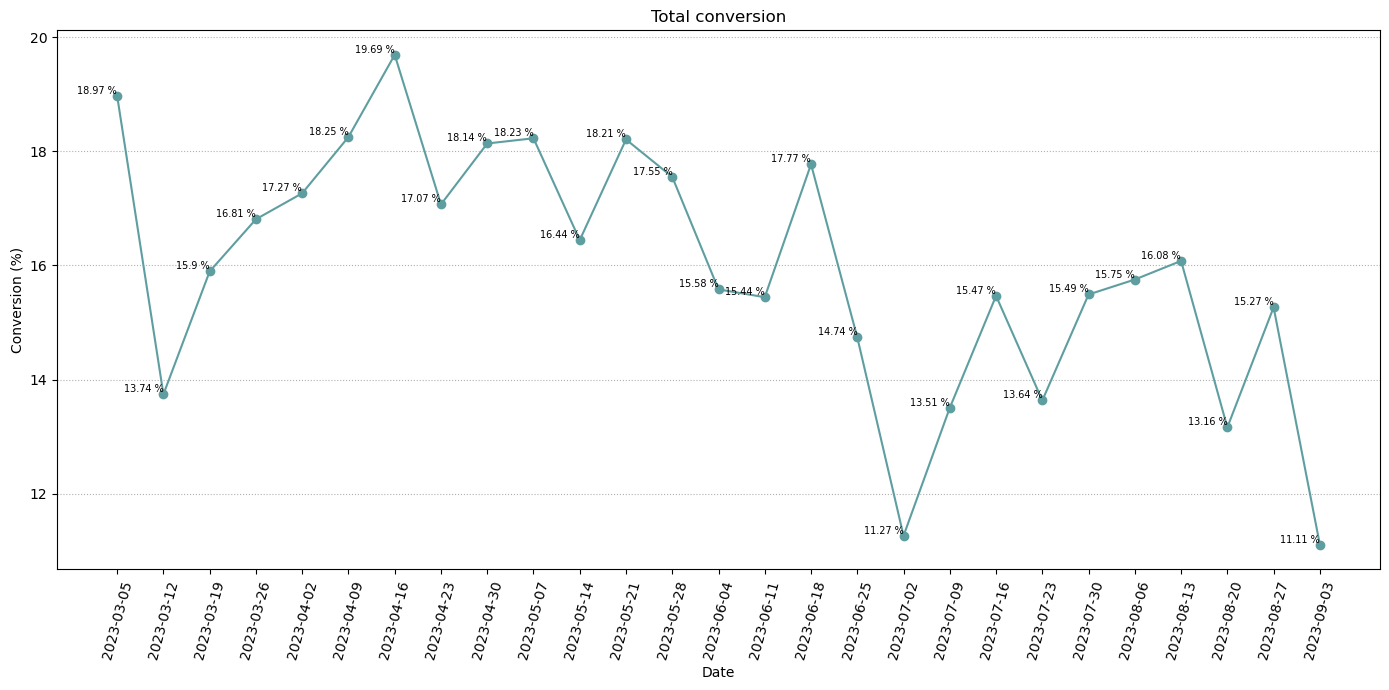

In [16]:
# общая конверсия посещение-решистрация

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(gr_dates['date_group'],
        gr_dates['conversion'],
        marker="o",
        color = 'cadetblue')

ax.set(xlabel='Date',
       ylabel='Conversion (%)',
       title='Total conversion')

for x, y in zip(gr_dates['date_group'], gr_dates['conversion']):
    plt.text(x, y, f"{round(y,2)} %", fontsize=7, ha='right', va='bottom')


plt.xticks(gr_dates['date_group'],
           rotation=75)
ax.grid(axis='y', ls=':')

plt.tight_layout()
plt.savefig('./charts/total_conversions.png')
plt.show()

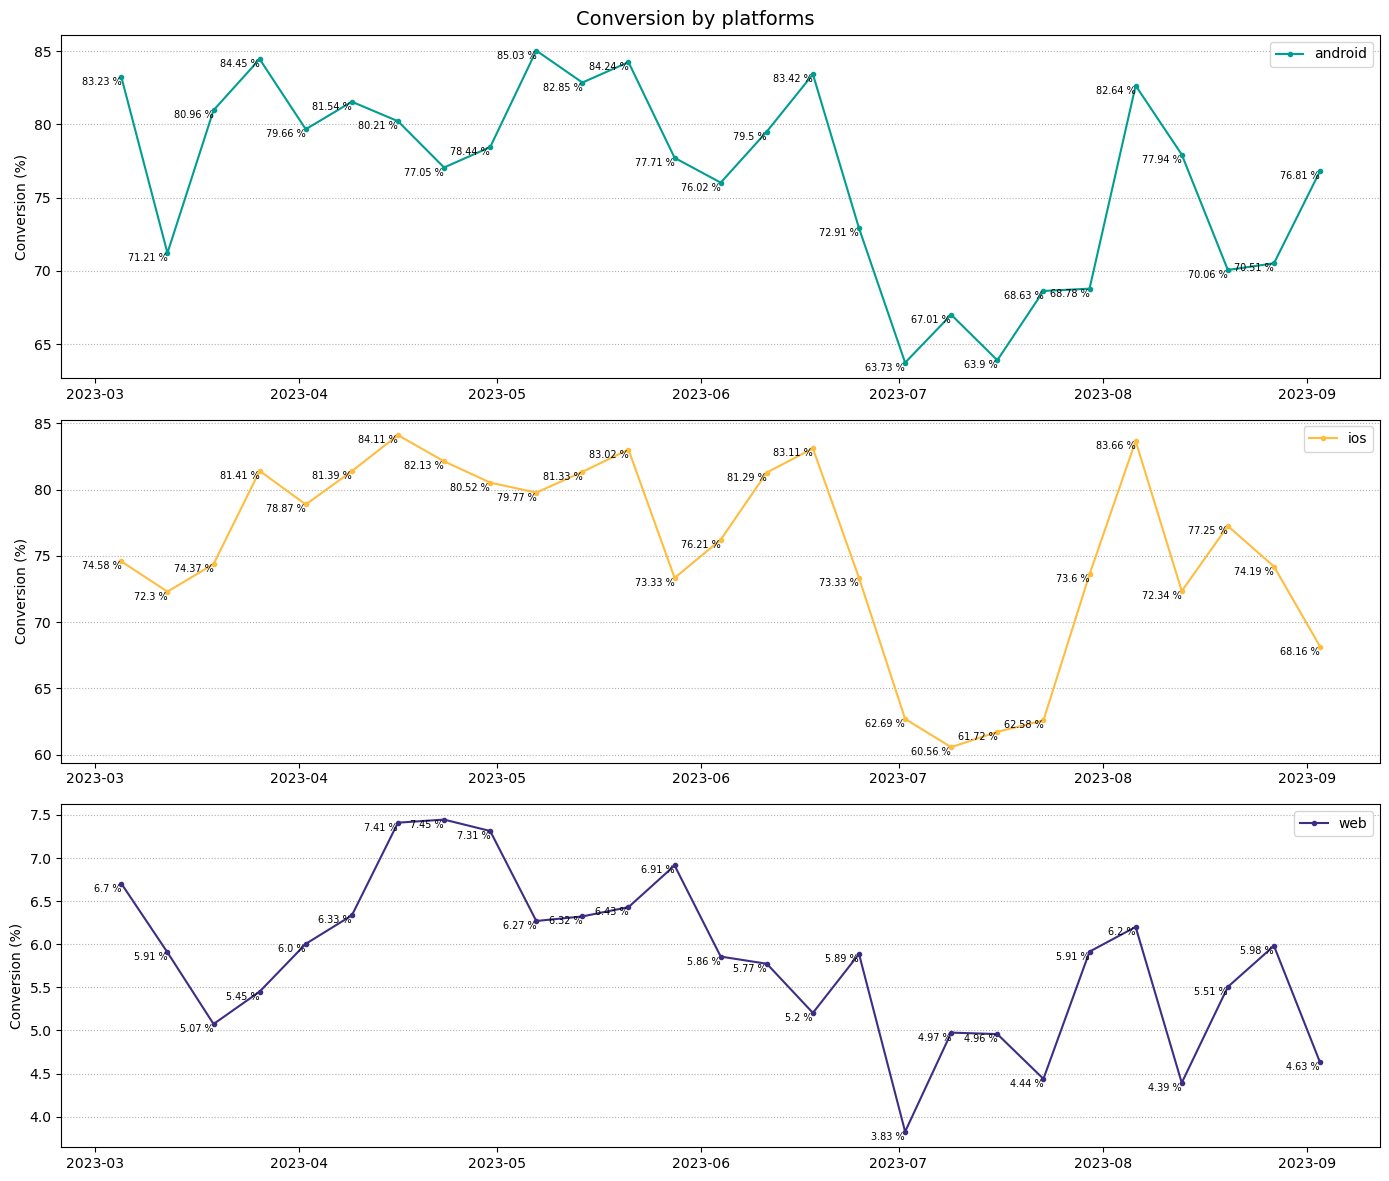

In [17]:
# конверсия по платформам

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(14, 12)
fig.suptitle('Conversion by platforms', fontsize=14)

def param_chart(ax_pos, pltf_df, pltf_name):
    ax[ax_pos].plot(pltf_df['date_group'],
                    pltf_df['conversion'],
                    marker=".",
                    color = charts_colors[pltf_name],
                    label=pltf_name)
    ax[ax_pos].legend()
    ax[ax_pos].set(ylabel='Conversion (%)')
    ax[ax_pos].tick_params('x',
                            rotation=0)
    ax[ax_pos].grid(axis='y', ls=':')
    for x, y in zip(pltf_df['date_group'], pltf_df['conversion']):
        ax[ax_pos].text(x, y, f"{round(y, 2)} %", fontsize=7, ha='right', va='top')
   
param_chart(0, android, 'android')
param_chart(1, ios, 'ios')
param_chart(2, web, 'web')

plt.tight_layout()
plt.savefig('./charts/conversion_by_platforms.png')
plt.show()

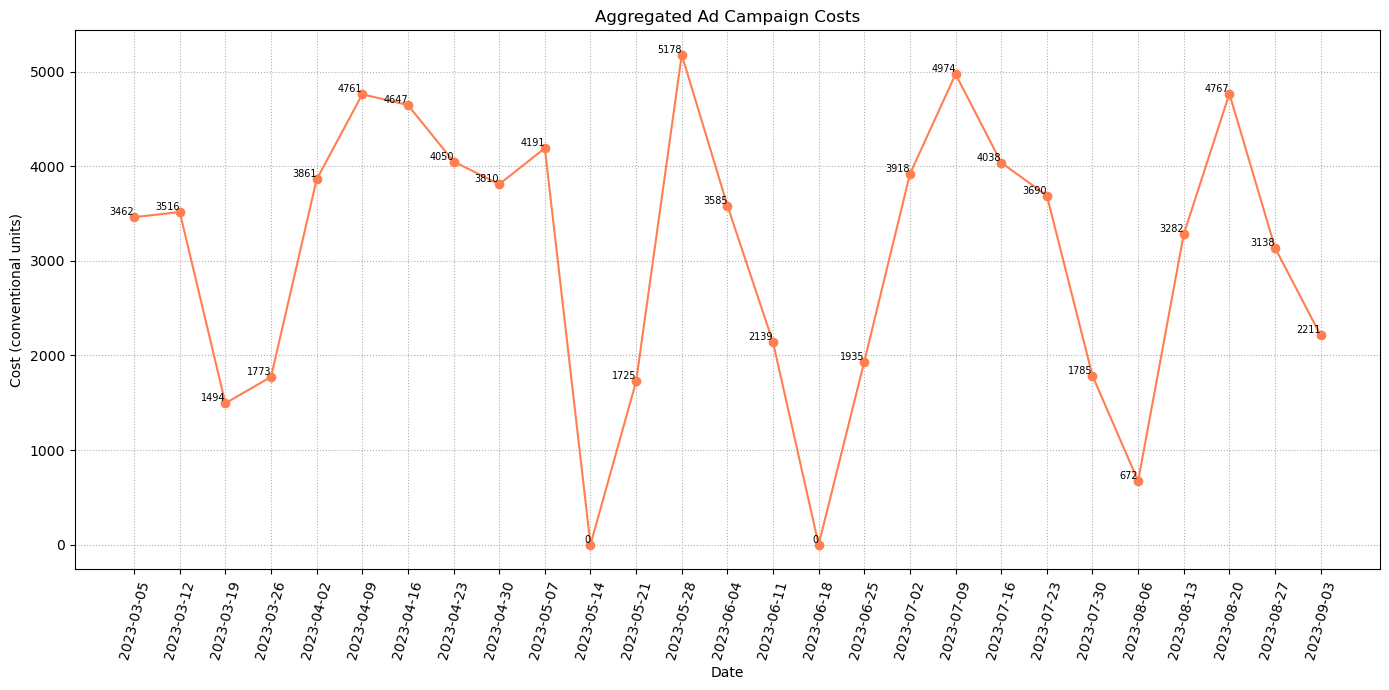

In [18]:
# расходы на рекламу

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(gr_dates['date_group'],
        gr_dates['cost'],
        marker="o",
        color = 'coral')

for x, y in zip(gr_dates['date_group'], gr_dates['cost']):
    plt.text(x, y, f"{round(y)}", fontsize=7, ha='right', va='bottom')
    
ax.set(xlabel='Date',
       ylabel='Cost (conventional units)',
       title='Aggregated Ad Campaign Costs')


plt.xticks(gr_dates['date_group'],
           rotation=75)
ax.grid(axis='both', ls=':')

plt.tight_layout()
plt.savefig('./charts/ads_cost.png')
plt.show()

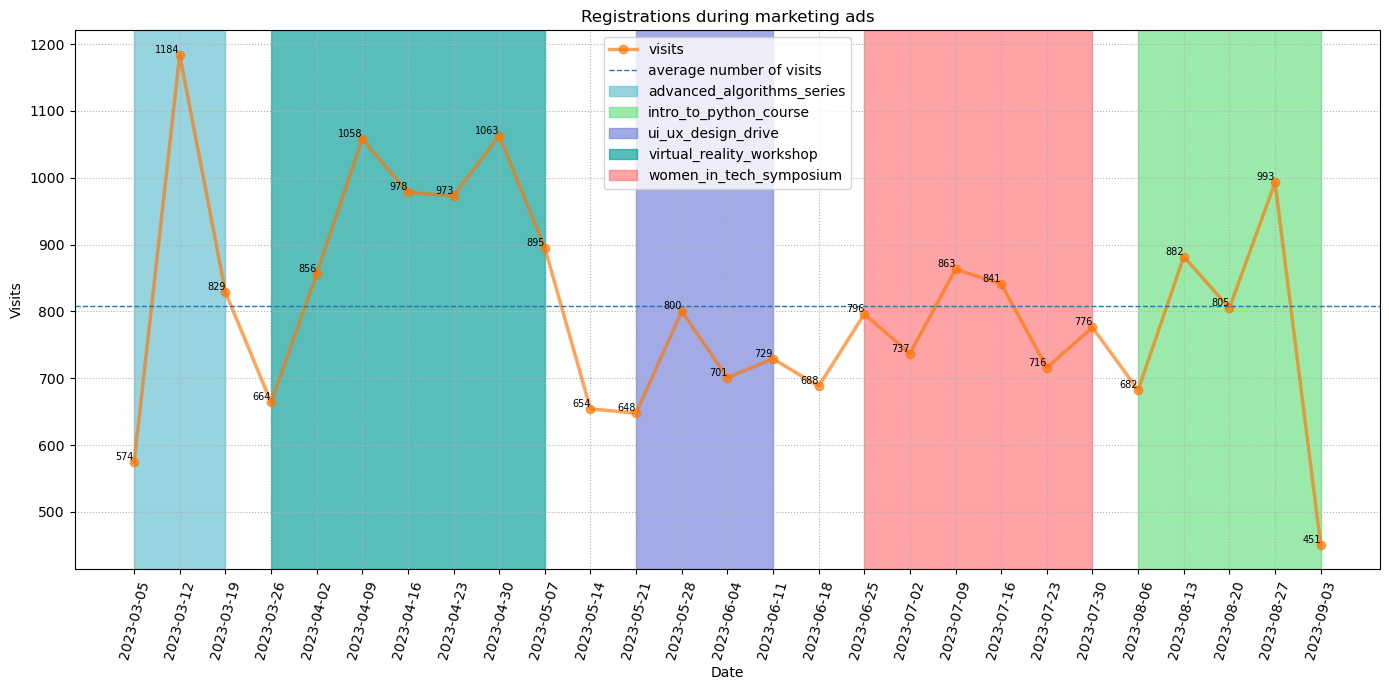

In [20]:
# регистрации с выделением рекламных кампаний

fig, ax = plt.subplots(figsize=(14, 7))

plt.plot(gr_dates['date_group'],
         gr_dates['registrations'],
         charts_colors['registrations'],
         linewidth=2.5,
         marker="o",
         label = 'visits',
         alpha = 0.65)

for x, y in zip(gr_dates['date_group'], gr_dates['registrations']):
    plt.text(x, y, f"{round(y)}", fontsize=7, ha='right', va='bottom')

plt.axhline(y=gr_dates['registrations'].mean(),
            linestyle='--',
            linewidth=1,
            label="average number of visits")
    
for tuple, series in gr_ads_dates.iterrows():
    plt.axvspan(series['min'],
                series['max'],
                label = series['utm_campaign'],
                color=charts_colors[series['utm_campaign']],
                alpha = 0.65)

ax.set(xlabel='Date',
       ylabel='Visits',
       title='Registrations during marketing ads')

ax.legend()
plt.xticks(gr_dates['date_group'],
           rotation=75)
ax.grid(axis='both', ls=':')

plt.tight_layout()
plt.savefig('./charts/registrations_during_marketing_ads.png')
plt.show()